In [59]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob

In [111]:
def plot_img(img_plot):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 1, 1)
    plt.imshow(img_plot)
    plt.axis('off')

    plt.show()

In [138]:
# TODO find best matches over a threshold

def find_template(img, tmp, threshold=None):
    min_scale = max(tmp.shape[0] / img.shape[0], tmp.shape[1] / img.shape[1])
    scales = np.linspace(min_scale, 4, 100)

    best_match = (0, 0, 0, 0)
    matches_above_threshold = []
    for scale in scales:
        image_scaled = cv2.resize(img, (0,0), fx=scale, fy=scale, interpolation= cv2.INTER_LINEAR)
        edges_scaled = cv2.Canny(image_scaled, 100, 200, L2gradient=True)
          
        if tmp.shape[0] < edges_scaled.shape[0] and tmp.shape[1] < edges_scaled.shape[1]:    
            result = cv2.matchTemplate(edges_scaled, tmp, cv2.TM_CCOEFF_NORMED)

            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
            w, h = tmp.shape[::-1]
            res = (
                        max_val, 
                        (round(max_loc[0]/scale), round(max_loc[1]/scale)), 
                        (round((max_loc[0] + w) / scale), round((max_loc[1] + h) / scale)), 
                        scale
                    )
            if threshold and max_val > threshold:
                matches_above_threshold.append(res)
            
            if max_val > best_match[0]:
                best_match = res
    
    return best_match, matches_above_threshold

In [129]:
def plot_match(res_img, best_match):
    _, top_left, bottom_right, _ = best_match
    cv2.rectangle(res_img, top_left, bottom_right, (0,255,0), 2)

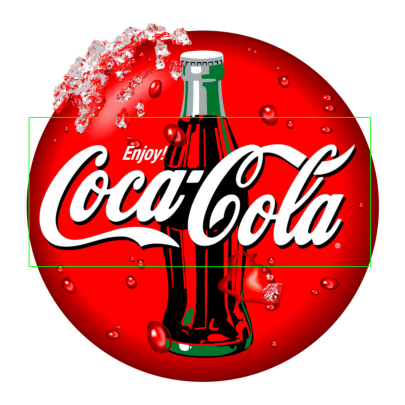

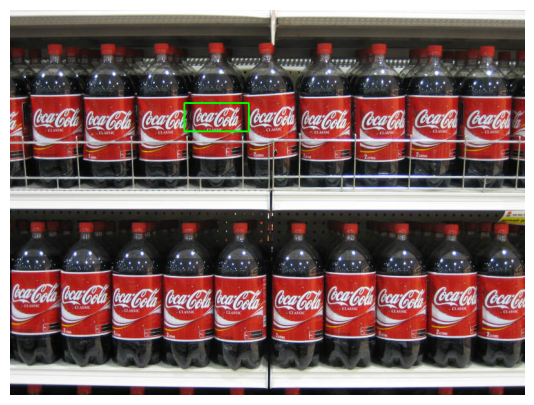

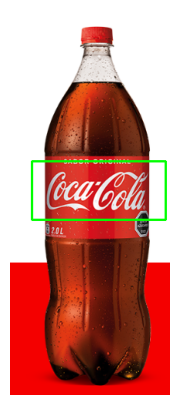

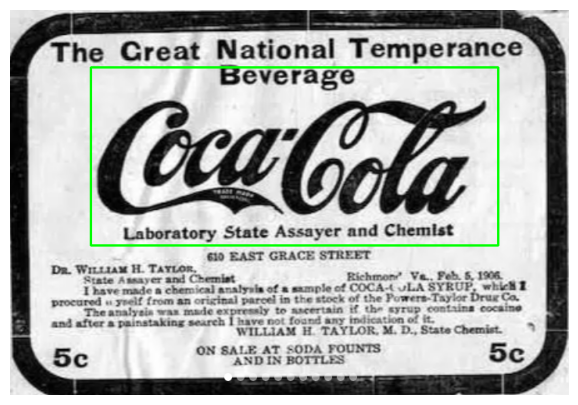

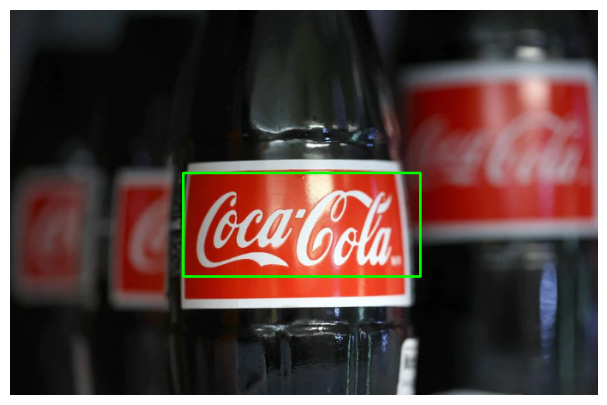

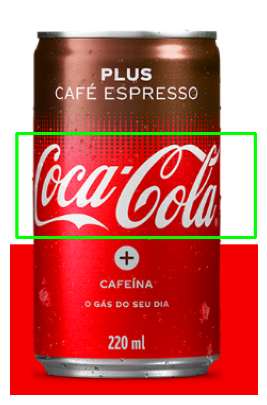

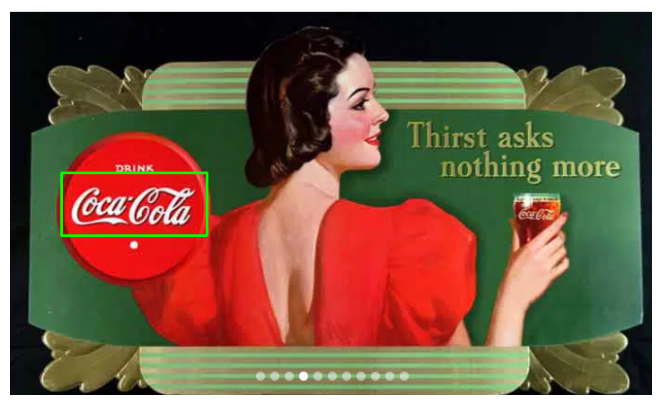

In [114]:
image_files = glob.glob('./data/images/*')
template = cv2.imread('./data/template/pattern.png', cv2.IMREAD_GRAYSCALE)
template_edges = cv2.Canny(template, 120, 240, L2gradient=True)

for image_file in image_files:
  image = cv2.imread(image_file)
  image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  match, best_matches = find_template(image_gray, template_edges)
  image_to_plot = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plot_match(image_to_plot, match)
  plot_img(image_to_plot)

In [117]:
def nms(matches, iou_threshold=0.5):
  if not matches:
    return []

  matches = sorted(matches, key=lambda x: x[0], reverse=True)
  retained_matches = []
  
  while matches:
    current_match = matches.pop(0)
    retained_matches.append(current_match)
    
    new_matches = []
    for match in matches:
      iou = calculate_iou(current_match[1], current_match[2], match[1], match[2])
      if iou < iou_threshold:
        new_matches.append(match)

    matches = new_matches

  return retained_matches

def calculate_iou(box1_top_left, box1_bottom_right, box2_top_left, box2_bottom_right):
  x1 = max(box1_top_left[0], box2_top_left[0])
  y1 = max(box1_top_left[1], box2_top_left[1])
  x2 = min(box1_bottom_right[0], box2_bottom_right[0])
  y2 = min(box1_bottom_right[1], box2_bottom_right[1])

  intersection_area = max(0, x2 - x1) * max(0, y2 - y1)

  box1_area = (box1_bottom_right[0] - box1_top_left[0]) * (box1_bottom_right[1] - box1_top_left[1])
  box2_area = (box2_bottom_right[0] - box2_top_left[0]) * (box2_bottom_right[1] - box2_top_left[1])

  iou = intersection_area / float(box1_area + box2_area - intersection_area)

  return iou

Original Matches:  43


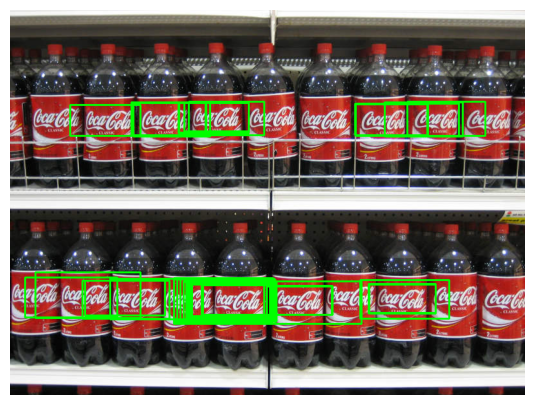

Matches after applying nms:  6


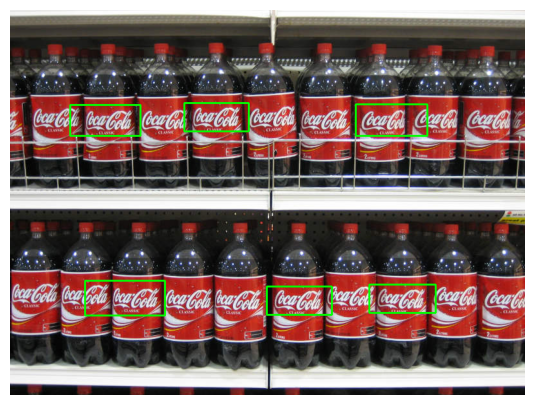

In [155]:
image = cv2.imread('./data/images/coca_multi.png')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

best_match, best_matches = find_template(image_gray, template_edges, 0.07)
nms_matches = nms(best_matches, 0.01)
nms_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
all_matches_image = nms_image.copy()

for match in best_matches:
    plot_match(all_matches_image, match)

print('Original Matches: ', len(best_matches))
plot_img(all_matches_image)

for match in nms_matches:
    plot_match(nms_image, match)

print('Matches after applying nms: ', len(nms_matches))
plot_img(nms_image)